# Log likelyhood of change-point location

Mathematics description:

This method is based on Baye's Formula :

$$p(\mu_1,\mu_2,\sigma,\tau|d) = \frac{p(d|\mu_1,\mu_2,\sigma,\tau)p(\mu_1,\mu_2,\sigma,\tau)}{p(d)}$$
where $p(\mu_1,\mu_2,\sigma,\tau|d)$ is named the posterior probalitity and $p(\mu_1,\mu_2,\sigma,\tau)$ the prior probability.
$p(d|\mu_1,\mu_2,\sigma,\tau)$ is the log-likelyhood that we maximized in the parametric method to find the maximum likelihood estimation.

We posses a sequence of data and we search for the point where the mean value chang i.e. :
$pts_k$ s.t. for $k\leq \tau$ the data follows $\sim\mathcal{N}(\mu_1,\sigma)$ and for $k≥\tau$ the data $\sim\mathcal{N}(\mu_2,\sigma)$.

We want to find $p(\tau,d)$ so we marginalize the postirior distribution $p(\mu_1,\mu_2,\sigma,\tau|d)$ w.r.t. $\mu_1,\mu_2,\sigma$.
Therefore, we have:
$$p(\tau|d) = \int_0^{\infty}d\sigma \int_{-\infty}^{\infty}d\mu_1 \int_{-\infty}^{\infty}d\mu_2 \times \frac{p(d|\mu_1,\mu_2,\sigma,\tau)}{\sigma}$$

To compute the likelihood we have two normal distribution $\mathcal{N}(\mu_1,\sigma)$ and $\mathcal{N}(\mu_2,\sigma)$  :

$$p(d|\mu_1,\mu_2,\sigma,\tau) = \prod_{i=1}^{\tau} p(d_i|\mu_1,\sigma)\prod_{i=\tau+1}^N p(d_i|\mu_2,\sigma)$$ 
$$=\frac{1}{(2\pi)^{\frac{N}{2}}\sigma^N} \exp{( -\frac{1}{2\sigma^2}\sum_{i=1}^{\tau}(x_i^2 + \mu_1^2 - 2\mu_1x_i) + -\frac{1}{2\sigma^2} \sum_{i=\tau+1}^{N}(x_i^2 + \mu_2^2 - 2\mu_2x_i)    )}$$

We perform three integrate w.r.t. $\mu_1,\mu_2,\sigma$ :

(i) $\mu_1$ :

$$p(\mu_2,\sigma,\tau|d) = \int_{-\infty}^{\infty} \frac{1}{(2\pi)^{\frac{N}{2}}\sigma^N} \exp{( -\frac{1}{2\sigma^2}\sum_{i=1}^{\tau}(x_i^2 + \mu_1^2 - 2\mu_1x_i) + -\frac{1}{2\sigma^2} \sum_{i=\tau+1}^{N}(x_i^2 + \mu_2^2 - 2\mu_2x_i)    )} d\mu_1$$
Using substitution we get :
$$p(\mu_1,\sigma,\tau|d) =  \frac{1}{(2\pi)^{\frac{N}{2}}\sigma^N} \times \sqrt{\frac{2\pi}{\tau}} \exp{(-\frac{1}{2\sigma^2}   (\sum_{i=1}^{\tau} x_i^2 - \frac{1}{\tau}  (\sum_{i=1}^{\tau} x_i)^2 -   \sum_{i=\tau+1}^{N} (x_i - \mu_2)^2    )   )}$$

(ii) $\mu_2$ :

$$p(\sigma,\tau|d) = \int_{-\infty}^{\infty} p(\mu_2,\sigma,\tau|d) d\mu_2$$
$$ p(\sigma,\tau|d) = \frac{(2\pi\sigma^2)^{-(N+1)/2}}{(\tau(N-\tau)^{1/2})} \exp{(-\frac{1}{2\sigma^2}   (\sum_{i=1}^{\tau} x_i^2 - \frac{1}{\tau}  (\sum_{i=1}^{\tau} x_i)^2 -   \frac{1}{N-\tau}(\sum_{i=\tau+1}^{N} x_i)^2    )   )}$$

(iii) $\sigma$ :

$$p(\tau|d) = \int_{0}^{\infty} p(\sigma,\tau|d) d\sigma$$
$$ p(\tau|d) = \frac{1}{\sqrt{\tau(N-\tau)}}  ( \sum_{i=1}^N x_i^2 - \frac{1}{\tau}  (\sum_{i=1}^{\tau} x_i)^2 -   \frac{1}{N-\tau}(\sum_{i=\tau+1}^{N} x_i)^2        )$$

To solve this proble mwe wil need an implementation of MCMC.

### MCMC algorithm

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def prior(param):
    """
    Check on sigma.
    
    Params:
    =======
        param (array_like): defines the mean and sigma values.
        
    Return:
    =======
        O or 1 depending on the validity of sigma (sigma < 0 fails)
    """
    return 1 if param[1] > 0 else 0


In [3]:
def loglikelihood(param, data):
    """
    Computes the log likelihood on the data given sigma
    
    Params:
    =======
         param (array_like): defines the mean and sigma values.
         data (array_like): the data on which to perform the log likelihood.
         
    Return:
    =======
        the log likelihood.
    """
    return np.sum(-np.log(param[1] * np.sqrt(2*np.pi)) - ((data-param[0])**2) / (2*param[1]**2))

In [17]:
def reject(loglik, loglik_new):
    """
    Select whether to reject or keep the sample
    
    Params:
    =======
        loglik : 
        loglike_new :
        
    Return:
    =======
        Boolean 
    """
    if loglik_new > loglik : return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < (np.exp(loglik_new - loglik)))

In [14]:
def HastingMetropolis(init_param, data,n_iter=10000):
    param = init_param
    accepted = []
    rejected = []
    for i in range(n_iter):
        param_new = [param[0],np.random.normal(param[1],0.5,(1,))[0]]
        loglik = loglikelihood(param,data)
        loglik_new = loglikelihood(param_new,data)
        reject_bool = reject(loglik + np.log(prior(param)), loglik_new+np.log(prior(param_new)))
        if reject_bool:
            param = param_new
            accepted.append(param_new)
        else:
            rejected.append(param_new)
    return np.array(accepted), np.array(rejected)

9.817066768685779

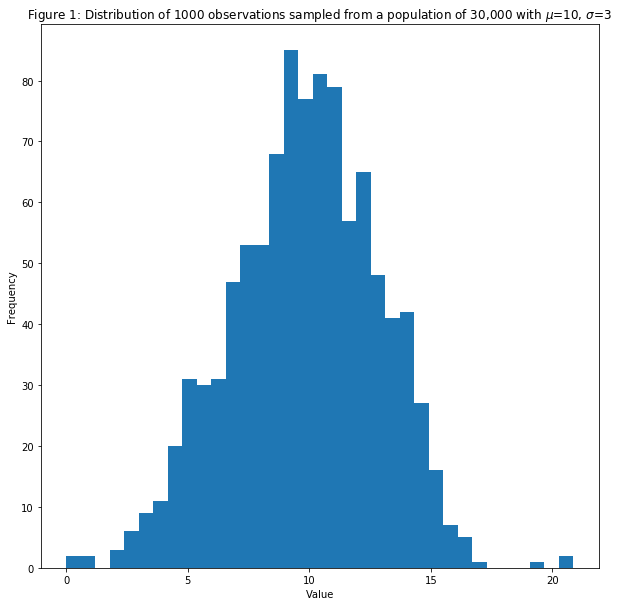

In [15]:
mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

In [18]:
accepted, rejected = HastingMetropolis([mu_obs,0.1],observation)

(1743, 2)

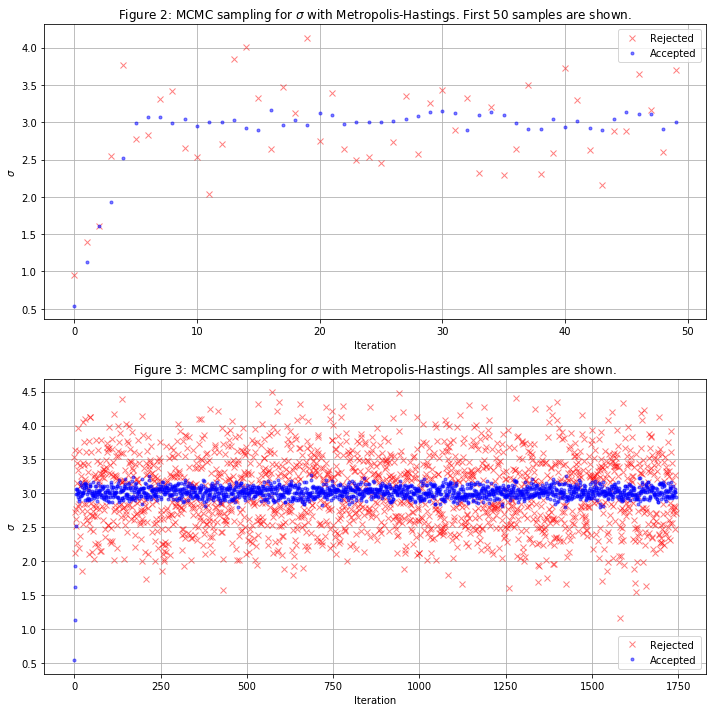

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape


### Bayesian Detection

We initialize the prior of our parameters using a uniform distribution.

In [ ]:
mu1 = np.random.uniform()